In [1]:
import uproot
import numpy as np
import time
from tensorflow.keras.models import load_model

import random

import PrimaryTierFileHelper
import Padding
from HigherTier import HigherTierFileHelper

In [2]:
#############################
# Let's read the file
#############################

fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0'
inputFileName = fileName + '.root'

treeFile = uproot.open(inputFileName)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

fileName_SAM = '/Users/isobel/Desktop/PostDoc/24_25/MPhys/ccnutree_SAM_0_v3.root'
treeFile_SAM = uproot.open(fileName_SAM)
tree_SAM = treeFile_SAM['ccnuselection/ccnusel']
branches_SAM = tree_SAM.arrays()

event_SAM = np.array(branches_SAM['Event_Event'])
run_SAM = np.array(branches_SAM['Event_Run'])
subrun_SAM = np.array(branches_SAM['Event_Subrun'])

In [3]:
#############################
# Get event-level stuff
#############################
event = np.array(branches['Event'])
subrun = np.array(branches['SubRun'])
run = np.array(branches['Run'])

trueNuVertexX = np.array(branches['NuX'])
trueNuVertexY = np.array(branches['NuY'])
trueNuVertexZ = np.array(branches['NuZ'])

recoNuVertexX = np.array(branches['RecoNuVtxX'])
recoNuVertexY = np.array(branches['RecoNuVtxY'])
recoNuVertexZ = np.array(branches['RecoNuVtxZ'])
isNC = np.array(branches['NC'])
nuPDG = np.array(branches['NuPdg'])
    
#############################
# Get primary link stuff 
#############################
# ID
primaryPFPIndex_main = branches['PrimaryPFPIndex']
primaryTrackShowerScore_main = branches['PrimaryTrackScore']
# link variables
primaryNSpacepoints_main = branches['PrimaryNSpacepoints']
primaryNuVertexSeparation_main = branches['PrimaryNuVertexSeparation']
primaryStartRegionNHits_main = branches['PrimaryStartRegionNHits']
primaryStartRegionNParticles_main = branches['PrimaryStartRegionNParticles']
primaryDCA_main = branches['PrimaryDCA']
primaryConnectionExtrapDistance_main = branches['PrimaryConnectionExtrapDistance']
primaryIsPOIClosestToNu_main = branches['PrimaryIsPOIClosestToNu']
# true
isTruePrimaryLink_main = branches['TruePrimaryLink']
isPrimaryLinkOrientationCorrect_main = branches['IsPrimaryLinkOrientationCorrect']

#############################
# Get higher tier link stuff
#############################
# ID
parentPFPIndex_main = branches['ParentPFPIndex']
childPFPIndex_main = branches['ChildPFPIndex']
trackShowerLinkType_main = branches['TrackShowerLinkType']
# Topology 
childStartX_main = branches['ChildStartX']
childStartY_main = branches['ChildStartY']
childStartZ_main = branches['ChildStartZ']
childStartDX_main = branches['ChildStartDX']
childStartDY_main = branches['ChildStartDY']
childStartDZ_main = branches['ChildStartDZ']
parentEndX_main = branches['ParentEndX']
parentEndY_main = branches['ParentEndY']
parentEndZ_main = branches['ParentEndZ']
parentEndDX_main = branches['ParentEndDX']
parentEndDY_main = branches['ParentEndDY']
parentEndDZ_main = branches['ParentEndDZ']
# link variables
parentTrackScore_main = branches['ParentTrackScore']
parentNuVertexSeparation_main = branches['ParentNuVertexSeparation']
parentEndRegionNHits_main = branches['ParentEndRegionNHits']
parentEndRegionNParticles_main = branches['ParentEndRegionNParticles']
parentEndRegionRToWall_main = branches['ParentEndRegionRToWall']
vertexSeparation_main = branches['VertexSeparation']
separation3D_main = branches['Separation3D']
doesChildConnect_main = branches['DoesChildConnect']
overshootStartDCA_main = branches['OvershootStartDCA']
overshootStartL_main = branches['OvershootStartL']
overshootEndDCA_main = branches['OvershootEndDCA']
overshootEndL_main = branches['OvershootEndL']
childConnectionDCA_main = branches['ChildConnectionDCA']
childConnectionExtrapDistance_main = branches['ChildConnectionExtrapDistance']
childConnectionLRatio_main = branches['ChildConnectionLRatio']
parentConnectionPointNUpstreamHits_main = branches['ParentConnectionPointNUpstreamHits']
parentConnectionPointNDownstreamHits_main = branches['ParentConnectionPointNDownstreamHits']
parentConnectionPointNHitRatio_main = branches['ParentConnectionPointNHitRatio']
parentConnectionPointEigenValueRatio_main = branches['ParentConnectionPointEigenValueRatio']
parentConnectionPointOpeningAngle_main = branches['ParentConnectionPointOpeningAngle']
isParentPOIClosestToNu_main = branches['IsParentPOIClosestToNu']
isChildPOIClosestToNu_main = branches['IsChildPOIClosestToNu']
pidLinkType_main = branches['PIDLinkType']
# training cut
trainingCutL_main = branches['TrainingCutL']
trainingCutT_main = branches['TrainingCutT']
# true
trueParentChildLink_main = branches['TrueParentChildLink']
isLinkOrientationCorrect_main = branches['IsLinkOrientationCorrect']

#############################
# Get node stuff
#############################
# node truth
pfpTruePDG_main = branches['RecoPFPTruePDG']
trueTrackID_main = branches['RecoPFPTrueTrackID']
# visible parent node truth
trueVisibleParentTrackID_main = branches['RecoPFPTrueVisibleParentTrackID']
trueVisibleParentPDG_main = branches['RecoPFPTrueVisibleParentPDG']
trueVisibleGeneration_main = branches['RecoPFPTrueVisibleGeneration']
trueVisibleParentPFPIndex_main = branches['RecoPFPTrueVisibleParentPFPIndex']
# generator parent node truth
trueGeneration_main = branches['RecoPFPTrueGeneration']
trueParentTrackID_main = branches['RecoPFPTrueParentTrackID']
trueParentPDG_main = branches['RecoPFPTrueParentPDG']
# node reco info
nSpacepoints_main = branches['RecoPFPRecoNSpacepoints']
trackShowerScore_main = branches['RecoPFPTrackShowerScore']
# Pandora metric stuff
trueVisibleParentSelf_main = branches['RecoPFPTrueVisibleParentSelf']
pandoraParentSelf_main = branches['RecoPFPRecoParentSelf']
pandoraGeneration_main = branches['RecoPFPRecoGeneration']

In [4]:
#np.where(np.logical_and(run == 1098, event == 31701))
print(np.where(np.logical_and(run == 1436, event == 1404))) # pointing back
print(np.where(np.logical_and(run == 1116, event == 87420))) # pointing back
print(np.where(np.logical_and(run == 1106, event == 73635))) # pointing back
print(np.where(np.logical_and(run == 1102, event == 56210))) # pointing back

(array([101203]),)
(array([101119]),)
(array([49534]),)
(array([5809]),)


In [5]:
#############################
# How many entries are we working with?
#############################
nEntries = event.shape[0]
print('We are working with:', nEntries, 'entries')

We are working with: 143300 entries


In [6]:
######################################
# Generate random indices to save
######################################
import math

n_events_test = 1

index_of_events_to_save = [101203]

while (len(index_of_events_to_save) != n_events_test) :
    iEvent_SAM = random.randint(0, (event_SAM.shape[0] - 1))
    
    index = np.where(np.logical_and(event == event_SAM[iEvent_SAM], run == run_SAM[iEvent_SAM]))[0]
    
    if len(index) == 0 :
        continue
        
    iEvent = index[0]

    if iEvent in index_of_events_to_save :
        continue
        
#     if np.count_nonzero(np.logical_and(event_SAM == event[iEvent], run_SAM == run[iEvent])) == 0 :
#         continue
    
    # Nu vertex vars - to work out separation
    dX = trueNuVertexX[iEvent] - recoNuVertexX[iEvent]
    dY = trueNuVertexY[iEvent] - recoNuVertexY[iEvent]
    dZ = trueNuVertexZ[iEvent] - recoNuVertexZ[iEvent]
    sep = math.sqrt((dX * dX) + (dY * dY) + (dZ * dZ)) 
            
    if (sep > 5.0) :
        continue
        
    print(len(index_of_events_to_save))
        
    index_of_events_to_save.append(iEvent)
#     print(len(index_of_events_to_save))
    

In [7]:
print(index_of_events_to_save)

[101203]


In [8]:
#######################################
# Set our model file paths
#######################################

# For track primary edge classification
PRIMARY_EDGE_TRACK_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel'        # to consider nu-track link 

# For shower primary edge classification
PRIMARY_EDGE_SHOWER_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower'      # to consider nu-shower link 

# For track-track higher tier edge classification
HIGHER_TIER_EDGE_TRACK_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel'          # to consider track-track link 

# For track-shower higher tier edge classification
HIGHER_TIER_EDGE_SHOWER_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower_oneModel'        # to consider track-shower link

In [9]:
############################
# Setup the models 
############################

# For track primary edge classification
primary_edge_track_tot_model = load_model(PRIMARY_EDGE_TRACK_TOT)   # to consider nu-track link 

# For shower primary edge classification
primary_edge_shower_tot_model = load_model(PRIMARY_EDGE_SHOWER_TOT) # to consider nu-shower link 

# For track-track higher tier edge classification
higher_edge_track_tot_model = load_model(HIGHER_TIER_EDGE_TRACK_TOT)   # to consider track-track link 

# For track-shower higher tier edge classification
higher_edge_shower_tot_model = load_model(HIGHER_TIER_EDGE_SHOWER_TOT) # to consider track-shower link

In [10]:
def getPrimaryOneModelInput_track(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)
    
    return input_0, input_1

def getOneModelInput_track(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)
    input_2 = np.concatenate((input_1[:,0:i_end_of_global_vars], input_1[:,i_target_start:], input_1[:,i_rest_start:i_rest_end]), axis=1)
    input_3 = np.concatenate((input_2[:,0:i_end_of_global_vars], input_2[:,i_target_start:], input_2[:,i_rest_start:i_rest_end]), axis=1)
    
    return input_0, input_1, input_2, input_3

def getOneModelInput_shower(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)

    return input_0, input_1

def getIndNetworkInput_2(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)

    return np.concatenate((input_0, input_1), axis=0)

def getTotNetworkInput_2(y_pred, nParticleLinks) :

    y_pred_0 = y_pred[0:nParticleLinks].reshape(-1, 1, 3)
    y_pred_1 = y_pred[nParticleLinks:(nParticleLinks * 2)].reshape(-1, 1, 3)

    return np.concatenate((y_pred_0, y_pred_1), axis=1).reshape(-1, 6)

In [11]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'
time.strftime('%l:%M%p %Z on %b %d, %Y') # ' 1:36PM EDT on Oct 18, 2010'

' 5:04PM GMT on Nov 15, 2024'

In [26]:
# iEvent = 101203

# print(np.where(np.logical_and(parentPFPIndex_main[iEvent] == 3, childPFPIndex_main[iEvent] == 6)))

# print(trainingCutL_main[iEvent][46])
# print(trainingCutL_main[iEvent][47])
# print(isLinkOrientationCorrect_main[iEvent][46])
# print(parentEndDX_main[iEvent][46])
# print(parentEndX_main[iEvent][46])
# print(branches['IsRecoTrackInverted'][iEvent][3])

(<Array [46, 47] type='2 * int64'>,)
-34.504456663505394
-34.504456663505394
True
0.8208393454551697
-170.4854278564453
True


In [12]:
###############################################
# Get our score vectors..
###############################################

primaryPFPIndex = []
isTruePrimaryLink = []
primaryTotNetworkPred = []
primaryIsTrack = []

parentPFPIndex = []
childPFPIndex = []
isTrueParentChildLink = []
higherTotNetworkPred = []
higherIsTrack = []
higherGen = []

trainingCutSep = []
trainingCutL = []
trainingCutT = []
trainingDCA = []

count = 0

for iEvent in index_of_events_to_save :
    
    if ((count % 100) == 0) :
        print('iEvent:', str(count) + '/' + str(len(index_of_events_to_save)))
        
    count = count + 1
    
    # For primary tier network
    primaryTierDict = {
        "primaryPFPIndex"                 : np.array(primaryPFPIndex_main[iEvent], dtype='int'), \
        "primaryTrackShowerScore"         : np.array(primaryTrackShowerScore_main[iEvent], dtype='float64'), \
        "primaryNSpacepoints"             : np.array(primaryNSpacepoints_main[iEvent], dtype='float64'), \
        "primaryNuVertexSeparation"       : np.array(primaryNuVertexSeparation_main[iEvent], dtype='float64'), \
        "primaryStartRegionNHits"         : np.array(primaryStartRegionNHits_main[iEvent], dtype='float64'), \
        "primaryStartRegionNParticles"    : np.array(primaryStartRegionNParticles_main[iEvent], dtype='float64'), \
        "primaryDCA"                      : np.array(primaryDCA_main[iEvent], dtype='float64'), \
        "primaryConnectionExtrapDistance" : np.array(primaryConnectionExtrapDistance_main[iEvent], dtype='float64'), \
        "primaryIsPOIClosestToNu"         : np.array(primaryIsPOIClosestToNu_main[iEvent], dtype='int'), \
        "isTruePrimaryLink"               : np.array(isTruePrimaryLink_main[iEvent], dtype='int'), \
        "isLinkOrientationCorrect"        : np.array(isPrimaryLinkOrientationCorrect_main[iEvent], dtype='bool')
    }
    
    # For higher tier network
    higherTierDict = {
        "parentPFPIndex"                       : np.array(parentPFPIndex_main[iEvent], dtype='int'), \
        "childPFPIndex"                        : np.array(childPFPIndex_main[iEvent], dtype='int'), \
        "trackShowerLinkType"                  : np.array(trackShowerLinkType_main[iEvent], dtype='float64'), \
        "parentTrackScore"                     : np.array(parentTrackScore_main[iEvent], dtype='float64'), \
        "parentNuVertexSeparation"             : np.array(parentNuVertexSeparation_main[iEvent], dtype='float64'), \
        "parentEndRegionNHits"                 : np.array(parentEndRegionNHits_main[iEvent], dtype='float64'), \
        "parentEndRegionNParticles"            : np.array(parentEndRegionNParticles_main[iEvent], dtype='float64'), \
        "parentEndRegionRToWall"               : np.array(parentEndRegionRToWall_main[iEvent], dtype='float64'), \
        "vertexSeparation"                     : np.array(vertexSeparation_main[iEvent], dtype='float64'), \
        "separation3D"                         : np.array(separation3D_main[iEvent], dtype='float64'), \
        "doesChildConnect"                     : np.array(doesChildConnect_main[iEvent], dtype='float64'), \
        "overshootStartDCA"                    : np.array(overshootStartDCA_main[iEvent], dtype='float64'), \
        "overshootStartL"                      : np.array(overshootStartL_main[iEvent], dtype='float64'), \
        "overshootEndDCA"                      : np.array(overshootEndDCA_main[iEvent], dtype='float64'), \
        "overshootEndL"                        : np.array(overshootEndL_main[iEvent], dtype='float64'), \
        "childConnectionDCA"                   : np.array(childConnectionDCA_main[iEvent], dtype='float64'), \
        "childConnectionExtrapDistance"        : np.array(childConnectionExtrapDistance_main[iEvent], dtype='float64'), \
        "childConnectionLRatio"                : np.array(childConnectionLRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointNUpstreamHits"   : np.array(parentConnectionPointNUpstreamHits_main[iEvent], dtype='float64'), \
        "parentConnectionPointNDownstreamHits" : np.array(parentConnectionPointNDownstreamHits_main[iEvent], dtype='float64'), \
        "parentConnectionPointNHitRatio"       : np.array(parentConnectionPointNHitRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointEigenValueRatio" : np.array(parentConnectionPointEigenValueRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointOpeningAngle"    : np.array(parentConnectionPointOpeningAngle_main[iEvent], dtype='float64'), \
        "isParentPOIClosestToNu"               : np.array(isParentPOIClosestToNu_main[iEvent], dtype='int'), \
        "isChildPOIClosestToNu"                : np.array(isChildPOIClosestToNu_main[iEvent], dtype='int'), \
        "pidLinkType"                          : np.array(pidLinkType_main[iEvent], dtype='float64'), \
        "trueParentChildLink"                  : np.array(trueParentChildLink_main[iEvent], dtype='int'), \
        "childStartX"                          : np.array(childStartX_main[iEvent], dtype='float64'), \
        "childStartY"                          : np.array(childStartY_main[iEvent], dtype='float64'), \
        "childStartZ"                          : np.array(childStartZ_main[iEvent], dtype='float64'), \
        "childStartDX"                         : np.array(childStartDX_main[iEvent], dtype='float64'), \
        "childStartDY"                         : np.array(childStartDY_main[iEvent], dtype='float64'), \
        "childStartDZ"                         : np.array(childStartDZ_main[iEvent], dtype='float64'), \
        "parentEndX"                           : np.array(parentEndX_main[iEvent], dtype='float64'), \
        "parentEndY"                           : np.array(parentEndY_main[iEvent], dtype='float64'), \
        "parentEndZ"                           : np.array(parentEndZ_main[iEvent], dtype='float64'), \
        "parentEndDX"                          : np.array(parentEndDX_main[iEvent], dtype='float64'), \
        "parentEndDY"                          : np.array(parentEndDY_main[iEvent], dtype='float64'), \
        "parentEndDZ"                          : np.array(parentEndDZ_main[iEvent], dtype='float64'), \
        "isLinkOrientationCorrect"             : np.array(isLinkOrientationCorrect_main[iEvent], dtype='int'), \
        "recoNuX"                              : recoNuVertexX[iEvent], \
        "recoNuY"                              : recoNuVertexY[iEvent], \
        "recoNuZ"                              : recoNuVertexZ[iEvent], \
        "trainingCutL"                         : np.array(trainingCutL_main[iEvent], dtype='float64'), \
        "trainingCutT"                         : np.array(trainingCutT_main[iEvent], dtype='float64'), \
    }
    
    ##########################################
    # Read primary network variables
    ##########################################
    primaryPFPIndex_track, variables_track, y_track, isTruePrimaryLink_track, trainingDCA_track, \
        primaryPFPIndex_shower, variables_shower, isTruePrimaryLink_shower, trainingDCA_shower = PrimaryTierFileHelper.readEvent(primaryTierDict, higherTierDict)
    
    nTracks_primary = isTruePrimaryLink_track.shape[0]
    nShowers_primary = isTruePrimaryLink_shower.shape[0]

#     print('nTracks_primary:', nTracks_primary)    
#     print('nShowers_primary:', nShowers_primary)
    
    #print(primaryPFPIndex_track)
    #print(branches['RecoPFPRecoNSpacepoints'][iEvent])
    
    if (nTracks_primary != 0) :
        totNetworkInput_track = getPrimaryOneModelInput_track(2, 1, 8, variables_track)
        totNetworkPred_track = primary_edge_track_tot_model.predict(totNetworkInput_track, verbose=0)[2].reshape(-1)
        
#         for i in range(0, y_track.shape[0]) :
#             print('y_track:', y_track[i])
#             print('isTrueParentChildLink_track:', isTrueParentChildLink_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i + (nTracks_higher)])
#             print('totNetworkPred_track:', totNetworkPred_track[i])
#             print('---------------')
        
    primaryPFPIndex.append(primaryPFPIndex_track if (nTracks_primary != 0) else np.empty(0))
    isTruePrimaryLink.append(isTruePrimaryLink_track if (nTracks_primary != 0) else np.empty(0))
    primaryTotNetworkPred.append(totNetworkPred_track if (nTracks_primary != 0) else np.empty(0))
    primaryIsTrack.append(np.ones(totNetworkPred_track.shape, dtype='int') if (nTracks_primary != 0) else np.empty(0))
    trainingDCA.append(trainingDCA_track if (nTracks_primary != 0) else np.empty(0))
        
    if (nShowers_primary != 0) :
        totNetworkPred_shower = primary_edge_shower_tot_model.predict(variables_shower, verbose=0).reshape(-1)
        
#         print('isTruePrimaryLink_shower:', isTruePrimaryLink_shower)
#         print('totNetworkPred_shower:', totNetworkPred_shower)
#         print('---------------')
        
    primaryPFPIndex[-1] = np.concatenate((primaryPFPIndex[-1], primaryPFPIndex_shower if (nShowers_primary != 0) else np.empty(0)))
    isTruePrimaryLink[-1] = np.concatenate((isTruePrimaryLink[-1], isTruePrimaryLink_shower if (nShowers_primary != 0) else np.empty(0)))
    primaryTotNetworkPred[-1] = np.concatenate((primaryTotNetworkPred[-1], totNetworkPred_shower if (nShowers_primary != 0) else np.empty(0)))
    primaryIsTrack[-1] = np.concatenate((primaryIsTrack[-1], np.zeros(totNetworkPred_shower.shape, dtype='int') if (nShowers_primary != 0) else np.empty(0)))
    trainingDCA[-1] = np.concatenate((trainingDCA[-1], trainingDCA_shower if (nShowers_primary != 0) else np.empty(0)))
            
    ##########################################
    # Read higher tier network variables
    ##########################################   
    parentPFPIndex_track, childPFPIndex_track, variables_track, y_track, isTrueParentChildLink_track, \
        trainingCutSep_track, trainingCutL_track, trainingCutT_track, \
        parentPFPIndex_shower, childPFPIndex_shower, variables_shower, y_shower, isTrueParentChildLink_shower, \
        trainingCutSep_shower, trainingCutL_shower, trainingCutT_shower = HigherTierFileHelper.readEvent(higherTierDict) 
    
    #print('parentPFPIndex_track:', parentPFPIndex_track)
    
    # I want to know the true generation, going to have to make this on the fly
    this_higherGen = []
    for childIndex in childPFPIndex_track :
        this_higherGen.append(trueVisibleGeneration_main[iEvent][childIndex])
        
    for childIndex in childPFPIndex_shower :
        this_higherGen.append(trueVisibleGeneration_main[iEvent][childIndex])
    
    higherGen.append(this_higherGen)
    
    nTracks_higher = isTrueParentChildLink_track.shape[0]
    nShowers_higher = isTrueParentChildLink_shower.shape[0]
    
#     print('nTracks_higher:', nTracks_higher)
#     print('nShowers_higher:', nShowers_higher)
    
    if (nTracks_higher != 0) :
        totNetworkInput_track = getOneModelInput_track(4, 3, 19, variables_track)
        totNetworkPred_track = higher_edge_track_tot_model.predict(totNetworkInput_track, verbose=0)[4].reshape(-1)
        
#         for i in range(0, y_track.shape[0]) :
#             print('y_track:', y_track[i])
#             print('isTrueParentChildLink_track:', isTrueParentChildLink_track[i])
#             print('totNetworkPred_track:', totNetworkPred_track[i])
#             print('---------------')

    parentPFPIndex.append(parentPFPIndex_track if (nTracks_higher != 0) else np.empty(0))
    childPFPIndex.append(childPFPIndex_track if (nTracks_higher != 0) else np.empty(0))
    isTrueParentChildLink.append(isTrueParentChildLink_track if (nTracks_higher != 0) else np.empty(0))
    higherTotNetworkPred.append(totNetworkPred_track if (nTracks_higher != 0) else np.empty(0))
    higherIsTrack.append(np.ones(totNetworkPred_track.shape, dtype='int') if (nTracks_higher != 0) else np.empty(0))
    trainingCutSep.append(trainingCutSep_track if (nTracks_higher != 0) else np.empty(0))
    trainingCutL.append(trainingCutL_track if (nTracks_higher != 0) else np.empty(0))
    trainingCutT.append(trainingCutT_track if (nTracks_higher != 0) else np.empty(0))
            
    if (nShowers_higher != 0) :
        totNetworkInput_shower = getOneModelInput_shower(2, 3, 19, variables_shower)
        totNetworkPred_shower = higher_edge_shower_tot_model.predict(totNetworkInput_shower, verbose=0)[2].reshape(-1)

#         for i in range(0, y_shower.shape[0]) :
#             print('y_shower:', y_shower[i])
#             print('isTrueParentChildLink_shower:', isTrueParentChildLink_shower[i])
#             print('totNetworkPred_shower:', totNetworkPred_shower[i])
#             print('---------------')


    parentPFPIndex[-1] = np.concatenate((parentPFPIndex[-1], parentPFPIndex_shower if (nShowers_higher != 0) else np.empty(0)))
    childPFPIndex[-1] = np.concatenate((childPFPIndex[-1], childPFPIndex_shower if (nShowers_higher != 0) else np.empty(0)))
    isTrueParentChildLink[-1] = np.concatenate((isTrueParentChildLink[-1], isTrueParentChildLink_shower if (nShowers_higher != 0) else np.empty(0)))
    higherTotNetworkPred[-1] = np.concatenate((higherTotNetworkPred[-1], totNetworkPred_shower if (nShowers_higher != 0) else np.empty(0)))     
    higherIsTrack[-1] = np.concatenate((higherIsTrack[-1], np.zeros(totNetworkPred_shower.shape, dtype='int') if (nShowers_higher != 0) else np.empty(0)))
    trainingCutSep[-1] = np.concatenate((trainingCutSep[-1], trainingCutSep_shower if (nShowers_higher != 0) else np.empty(0)))
    trainingCutL[-1] = np.concatenate((trainingCutL[-1], trainingCutL_shower if (nShowers_higher != 0) else np.empty(0)))
    trainingCutT[-1] = np.concatenate((trainingCutT[-1], trainingCutT_shower if (nShowers_higher != 0) else np.empty(0)))

iEvent: 0/2000
iEvent: 100/2000
iEvent: 200/2000
iEvent: 300/2000
iEvent: 400/2000
iEvent: 500/2000
iEvent: 600/2000
iEvent: 700/2000
iEvent: 800/2000
iEvent: 900/2000
iEvent: 1000/2000
iEvent: 1100/2000
iEvent: 1200/2000
iEvent: 1300/2000
iEvent: 1400/2000
iEvent: 1500/2000
iEvent: 1600/2000
iEvent: 1700/2000
iEvent: 1800/2000
iEvent: 1900/2000


In [13]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'
time.strftime('%l:%M%p %Z on %b %d, %Y') # ' 1:36PM EDT on Oct 18, 2010'

'12:39PM GMT on Nov 15, 2024'

In [14]:

# ALSO NEED TO REMOVE TRACK/SHOWER LINK TYPE FROM MODELS

print('remember!')
print(higherTierDict['trueParentChildLink'])

remember!
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


signal_scores_track: 5142
signal_scores_shower: 2689
background_scores_track: 1744
background_scores_shower: 1472


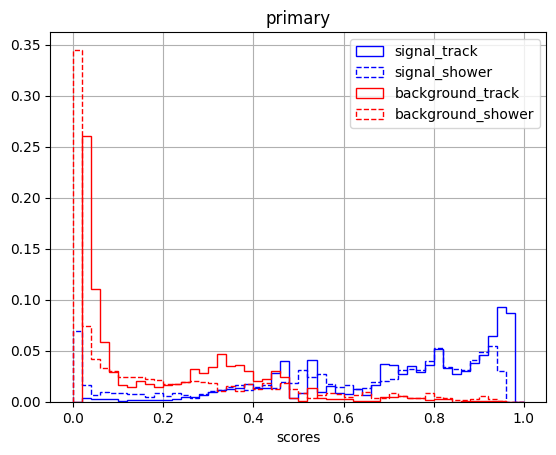

signal_scores_track: 1557
signal_scores_shower: 1011
background_scores_track: 29939
background_scores_shower: 18781


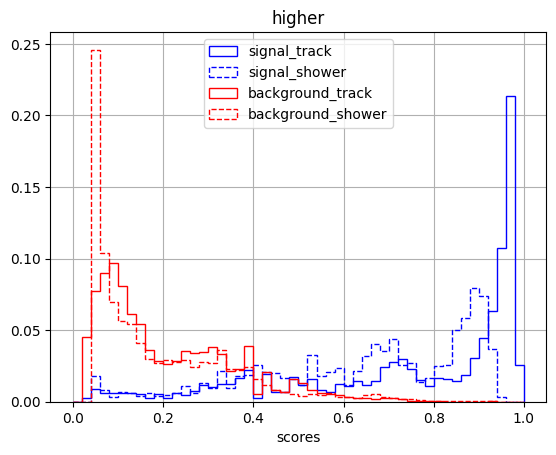

In [15]:
##############################################################
# Check that signal/background distributions are as expected
##############################################################

from matplotlib import pyplot as plt

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

def draw(scores, truth, isTrack, graph_label, normalise) :
    
    signal_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    background_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    flat_truth = np.array(flatten_comprehension(truth)).reshape(-1)
    flat_is_track = np.array(flatten_comprehension(isTrack)).reshape(-1)
    
    signal_scores_track = signal_scores[np.logical_and(flat_truth == 1, flat_is_track == 1)]
    signal_scores_shower = signal_scores[np.logical_and(flat_truth == 1, flat_is_track == 0)]
    background_scores_track = background_scores[np.logical_and(flat_truth == 0, flat_is_track == 1)]
    background_scores_shower = background_scores[np.logical_and(flat_truth == 0, flat_is_track == 0)]
    
    print('signal_scores_track:', len(signal_scores_track))
    print('signal_scores_shower:', len(signal_scores_shower))
    print('background_scores_track:', len(background_scores_track))
    print('background_scores_shower:', len(background_scores_shower))
    
    signal_weights_track = (1.0 / float(signal_scores_track.shape[0])) if normalise else 1.0
    signal_weights_track = np.ones(signal_scores_track.shape[0]) * signal_weights_track
    signal_weights_shower = (1.0 / float(signal_scores_shower.shape[0])) if normalise else 1.0
    signal_weights_shower = np.ones(signal_scores_shower.shape[0]) * signal_weights_shower
        
    background_weights_track = (1.0 / float(background_scores_track.shape[0])) if normalise else 1.0
    background_weights_track = np.ones(background_scores_track.shape[0]) * background_weights_track  
    background_weights_shower = (1.0 / float(background_scores_shower.shape[0])) if normalise else 1.0
    background_weights_shower = np.ones(background_scores_shower.shape[0]) * background_weights_shower
    
    plt.hist(signal_scores_track, range = [0,1], bins=50, color='blue', label='signal_track', weights=signal_weights_track, fill=False, histtype='step')
    plt.hist(signal_scores_shower, range = [0,1], bins=50, color='blue', label='signal_shower', weights=signal_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.hist(background_scores_track, range = [0,1], bins=50, color='red', label='background_track', weights=background_weights_track, fill=False, histtype='step')
    plt.hist(background_scores_shower, range = [0,1], bins=50, color='red', label='background_shower', weights=background_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.title(graph_label)
    plt.xlabel('scores')
    plt.legend()
    plt.grid(True)
    plt.show() 
    
# def drawGen(scores, truth, isTrack, generation, graph_label, normalise, target_gen) :
    
#     signal_scores = np.array(flatten_comprehension(scores)).reshape(-1)
#     background_scores = np.array(flatten_comprehension(scores)).reshape(-1)
#     flat_truth = np.array(flatten_comprehension(truth)).reshape(-1)
#     flat_is_track = np.array(flatten_comprehension(isTrack)).reshape(-1)
#     flat_gen = np.array(flatten_comprehension(generation)).reshape(-1)
    
#     signal_scores_track = signal_scores[np.logical_and(flat_truth == 1, np.logical_and(flat_is_track == 1, flat_gen == target_gen))]
#     signal_scores_shower = signal_scores[np.logical_and(flat_truth == 1, np.logical_and(flat_is_track == 0, flat_gen == target_gen))]
#     background_scores_track = background_scores[np.logical_and(flat_truth == 0, np.logical_and(flat_is_track == 1, flat_gen == target_gen))]
#     background_scores_shower = background_scores[np.logical_and(flat_truth == 0, np.logical_and(flat_is_track == 0, flat_gen == target_gen))]
    
#     signal_weights_track = (1.0 / float(signal_scores_track.shape[0])) if normalise else 1.0
#     signal_weights_track = np.ones(signal_scores_track.shape[0]) * signal_weights_track
#     signal_weights_shower = (1.0 / float(signal_scores_shower.shape[0])) if normalise else 1.0
#     signal_weights_shower = np.ones(signal_scores_shower.shape[0]) * signal_weights_shower
        
#     background_weights_track = (1.0 / float(background_scores_track.shape[0])) if normalise else 1.0
#     background_weights_track = np.ones(background_scores_track.shape[0]) * background_weights_track  
#     background_weights_shower = (1.0 / float(background_scores_shower.shape[0])) if normalise else 1.0
#     background_weights_shower = np.ones(background_scores_shower.shape[0]) * background_weights_shower
    
#     plt.hist(signal_scores_track, range = [0,1], bins=50, color='blue', label='signal_track', weights=signal_weights_track, fill=False, histtype='step')
#     plt.hist(signal_scores_shower, range = [0,1], bins=50, color='blue', label='signal_shower', weights=signal_weights_shower, fill=False, histtype='step', linestyle='dashed')
#     plt.hist(background_scores_track, range = [0,1], bins=50, color='red', label='background_track', weights=background_weights_track, fill=False, histtype='step')
#     plt.hist(background_scores_shower, range = [0,1], bins=50, color='red', label='background_shower', weights=background_weights_shower, fill=False, histtype='step', linestyle='dashed')
#     plt.title(graph_label)
#     plt.xlabel('scores')
#     plt.legend()
#     plt.grid(True)
#     plt.show() 
    
draw(primaryTotNetworkPred, isTruePrimaryLink, primaryIsTrack, 'primary', True)
draw(higherTotNetworkPred, isTrueParentChildLink, higherIsTrack, 'higher', True)

# drawGen(higherTotNetworkPred, isTrueParentChildLink, higherIsTrack, higherGen, 'higher - child true gen 4', True, 3)

In [16]:
# pfpTruePDG_main = pfpTruePDG_main[:n_events_test]
# trueTrackID_main = trueTrackID_main[:n_events_test]
# trueVisibleParentTrackID_main = trueVisibleParentTrackID_main[:n_events_test]
# trueVisibleGeneration_main = trueVisibleGeneration_main[:n_events_test]
# trueVisibleParentPFPIndex_main = trueVisibleParentPFPIndex_main[:n_events_test]
# nSpacepoints_main = nSpacepoints_main[:n_events_test]
# trackShowerScore_main = trackShowerScore_main[:n_events_test]
# pandoraGeneration_main = pandoraGeneration_main[:n_events_test]
# pandoraParentSelf_main = pandoraParentSelf_main[:n_events_test]
# trueVisibleParentSelf = trueVisibleParentSelf[:n_events_test]

In [17]:
event_trunc = [event[i] for i in index_of_events_to_save]
subrun_trunc = [subrun[i] for i in index_of_events_to_save]
run_trunc = [run[i] for i in index_of_events_to_save]
isNC_trunc = [isNC[i] for i in index_of_events_to_save]
nuPDG_trunc = [nuPDG[i] for i in index_of_events_to_save]

#############################
# Node stuff
#############################
# Node truth
pfpTruePDG_trunc = [pfpTruePDG_main[i] for i in index_of_events_to_save]
trueTrackID_trunc = [trueTrackID_main[i] for i in index_of_events_to_save]
# Visible parent node truth
trueVisibleParentTrackID_trunc = [trueVisibleParentTrackID_main[i] for i in index_of_events_to_save]
trueVisibleParentPDG_trunc = [trueVisibleParentPDG_main[i] for i in index_of_events_to_save]
trueVisibleGeneration_trunc = [trueVisibleGeneration_main[i] for i in index_of_events_to_save]
trueVisibleParentPFPIndex_trunc = [trueVisibleParentPFPIndex_main[i] for i in index_of_events_to_save]
# Generator parent node truth
trueGeneration_trunc = [trueGeneration_main[i] for i in index_of_events_to_save]
trueParentTrackID_trunc = [trueParentTrackID_main[i] for i in index_of_events_to_save]
trueParentPDG_trunc = [trueParentPDG_main[i] for i in index_of_events_to_save]
# node reco info
nSpacepoints_trunc = [nSpacepoints_main[i] for i in index_of_events_to_save]
trackShowerScore_trunc = [trackShowerScore_main[i] for i in index_of_events_to_save]
# Pandora metrics stuff
trueVisibleParentSelf_trunc = [trueVisibleParentSelf_main[i] for i in index_of_events_to_save]
pandoraParentSelf_trunc = [pandoraParentSelf_main[i] for i in index_of_events_to_save]
pandoraGeneration_trunc = [pandoraGeneration_main[i] for i in index_of_events_to_save]

In [18]:
####################
# Create file mask
####################

# Particle node
particle_max_length = Padding.get_max_length(pfpTruePDG_trunc)
particle_mask_main = [Padding.create_mask(entry, particle_max_length) for entry in pfpTruePDG_trunc]
particle_mask_main = np.array(particle_mask_main)

print('particle_max_length:', particle_max_length)

# Primary links
primary_link_max_length = Padding.get_max_length(primaryPFPIndex)
primary_link_mask_main = [Padding.create_mask(entry, primary_link_max_length) for entry in primaryPFPIndex]
primary_link_mask_main = np.array(primary_link_mask_main)

print('primary_link_max_length:', primary_link_max_length)

# Higher links
higher_link_max_length = Padding.get_max_length(parentPFPIndex)
higher_link_mask_main = [Padding.create_mask(entry, higher_link_max_length) for entry in parentPFPIndex]
higher_link_mask_main = np.array(higher_link_mask_main)

print('primary_link_max_length:', higher_link_max_length)

particle_max_length: 37
primary_link_max_length: 32
primary_link_max_length: 609


In [19]:
##############################
# Pad vectors
##############################

#############################
# Get event-level stuff
#############################
# Don't need to pad these!

#############################
# Get node stuff
#############################
# Node truth
pfpTruePDG_main = Padding.process_array(pfpTruePDG_trunc, particle_max_length)
trueTrackID_main = Padding.process_array(trueTrackID_trunc, particle_max_length)
# Visible parent node truth
trueVisibleParentTrackID_main = Padding.process_array(trueVisibleParentTrackID_trunc, particle_max_length)
trueVisibleParentPDG_main = Padding.process_array(trueVisibleParentPDG_trunc, particle_max_length)
trueVisibleGeneration_main = Padding.process_array(trueVisibleGeneration_trunc, particle_max_length)
trueVisibleParentPFPIndex_main = Padding.process_array(trueVisibleParentPFPIndex_trunc, particle_max_length)
# Generator parent node truth
trueGeneration_main = Padding.process_array(trueGeneration_trunc, particle_max_length)
trueParentTrackID_main = Padding.process_array(trueParentTrackID_trunc, particle_max_length)
trueParentPDG_main = Padding.process_array(trueParentPDG_trunc, particle_max_length)
# Node reco stuff
nSpacepoints_main = Padding.process_array(nSpacepoints_trunc, particle_max_length)
trackShowerScore_main = Padding.process_array(trackShowerScore_trunc, particle_max_length)
# Pandora metrics stuff
trueVisibleParentSelf_main = Padding.process_array(trueVisibleParentSelf_trunc, particle_max_length)
pandoraParentSelf_main = Padding.process_array(pandoraParentSelf_trunc, particle_max_length)
pandoraGeneration_main = Padding.process_array(pandoraGeneration_trunc, particle_max_length)

#############################
# Get primary link stuff primary_link_max_length
#############################
primaryPFPIndex_main = Padding.process_array(primaryPFPIndex, primary_link_max_length)
isTruePrimaryLink_main = Padding.process_array(isTruePrimaryLink, primary_link_max_length)
primaryTotNetworkPred_main = Padding.process_array(primaryTotNetworkPred, primary_link_max_length)
trainingDCA_main = Padding.process_array(trainingDCA, primary_link_max_length)

#############################
# Get higher tier link stuff higher_link_max_length
#############################
parentPFPIndex_main = Padding.process_array(parentPFPIndex, higher_link_max_length)
childPFPIndex_main = Padding.process_array(childPFPIndex, higher_link_max_length)
isTrueParentChildLink_main = Padding.process_array(isTrueParentChildLink, higher_link_max_length)
higherTotNetworkPred_main = Padding.process_array(higherTotNetworkPred, higher_link_max_length)
higherIsTrack_main = Padding.process_array(higherIsTrack, higher_link_max_length)
trainingCutSep_main = Padding.process_array(trainingCutSep, higher_link_max_length)
trainingCutL_main = Padding.process_array(trainingCutL, higher_link_max_length)
trainingCutT_main = Padding.process_array(trainingCutT, higher_link_max_length)

In [20]:
file = 'networkscores_0_oneModel_JAM'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'
    
np.savez(outputFile, \
         event = event_trunc, \
         subrun = subrun_trunc, \
         run = run_trunc, \
         isNC = isNC_trunc,
         nuPDG = nuPDG_trunc,
         particleMask = particle_mask_main, \
         pfpTruePDG = pfpTruePDG_main, \
         trueTrackID = trueTrackID_main, \
         trueVisibleParentTrackID = trueVisibleParentTrackID_main, \
         trueVisibleParentPDG = trueVisibleParentPDG_main, \
         trueVisibleGeneration = trueVisibleGeneration_main, \
         trueVisibleParentPFPIndex = trueVisibleParentPFPIndex_main, \
         trueGeneration = trueGeneration_main, \
         trueParentTrackID = trueParentTrackID_main, \
         trueParentPDG = trueParentPDG_main, \
         nSpacepoints = nSpacepoints_main, \
         trackShowerScore = trackShowerScore_main, \
         trueVisibleParentSelf = trueVisibleParentSelf_main, \
         pandoraParentSelf = pandoraParentSelf_main, \
         pandoraGeneration = pandoraGeneration_main, \
         primaryLinkMask = primary_link_mask_main, \
         primaryPFPIndex = primaryPFPIndex_main, \
         isTruePrimaryLink = isTruePrimaryLink_main, \
         primaryTotNetworkPred = primaryTotNetworkPred_main, \
         trainingDCA = trainingDCA_main, \
         higherLinkMask = higher_link_mask_main, \
         parentPFPIndex = parentPFPIndex_main, \
         childPFPIndex = childPFPIndex_main, \
         isTrueParentChildLink = isTrueParentChildLink_main, \
         higherTotNetworkPred = higherTotNetworkPred_main, \
         higherIsTrack = higherIsTrack_main, \
         trainingCutSep = trainingCutSep_main, \
         trainingCutL = trainingCutL_main, \
         trainingCutT = trainingCutT_main)